# Spark GraphFrames

Spark GraphFrames is a package that you need to install separately. Assuming you have a local Spark installation working, this is what I had to do.

Note: The documentation suggests using `--package` rather than `--jars` but that did not work for me.

Environment variables 
```bash
export SPARK_HOME=/usr/local/spark
export PYSPARK_PYTHON=python3
export PYSPARK_DRIVER_PYTHON=jupyter
export PYSPARK_DRIVER_PYTHON_OPTS=notebook
```

Download the GraphFrames package and move to the spark `jars` folder
```bash
wget http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
cp 0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar $SPARK_HOME/jars/
```

Start `pyspark` on command line with
```bash
pyspark --jars graphframes-0.8.1-spark3.0-s_2.12.jar
```

You can also set this as an environment variable.

```bash
export SPARK_OPTS="--jars graphframes-0.8.1-spark3.0-s_2.12.jar"
```

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = (
    SparkSession.builder 
    .master("local") 
    .appName("BIOS-823") 
    .config("spark.executor.cores", 4) 
    .getOrCreate()    
)

In [3]:
from graphframes import *

### Utility plotting function

In [4]:
import networkx as nx

def plot_graph(es):
    g = nx.DiGraph()
    for row in es.select('src','dst').collect():
        g.add_edge(row['src'],row['dst'])

    nx.draw(g, with_labels=True, node_color='yellow')

## Graph construction

In [5]:
vs = spark.createDataFrame(
    [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e')],
    ['id', 'name']
)

es = spark.createDataFrame([
    (1, 2, 'friend'),
    (1, 3, 'friend'),
    (2, 3, 'friend'),
    (1, 4, 'enemy'),
    (1, 5, 'enemy'),
    (2, 4, 'fried'),
    (5, 3, 'friend')],
    ['src', 'dst', 'type']
)

In [6]:
g = GraphFrame(vs, es)

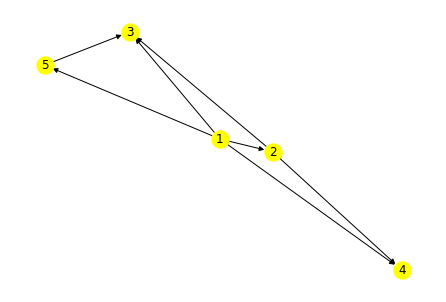

In [7]:
plot_graph(g.edges)

In [8]:
g.vertices.show()

+---+----+
| id|name|
+---+----+
|  1|   a|
|  2|   b|
|  3|   c|
|  4|   d|
|  5|   e|
+---+----+



In [9]:
g.edges.show()

+---+---+------+
|src|dst|  type|
+---+---+------+
|  1|  2|friend|
|  1|  3|friend|
|  2|  3|friend|
|  1|  4| enemy|
|  1|  5| enemy|
|  2|  4| fried|
|  5|  3|friend|
+---+---+------+



In [10]:
g.degrees.show()

+---+------+
| id|degree|
+---+------+
|  5|     2|
|  1|     4|
|  3|     3|
|  2|     3|
|  4|     2|
+---+------+



In [11]:
g.inDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  5|       1|
|  3|       3|
|  2|       1|
|  4|       2|
+---+--------+



In [12]:
g.outDegrees.show()

+---+---------+
| id|outDegree|
+---+---------+
|  5|        1|
|  1|        4|
|  2|        2|
+---+---------+



### Nodes and edges are just  DataFrames

They can be manipulated using the usual methods.

In [13]:
g.vertices.filter('id % 2 != 0').show()

+---+----+
| id|name|
+---+----+
|  1|   a|
|  3|   c|
|  5|   e|
+---+----+



In [14]:
import pyspark.sql.functions as F

In [15]:
g.vertices.withColumn('val', F.expr('id*id')).show()

+---+----+---+
| id|name|val|
+---+----+---+
|  1|   a|  1|
|  2|   b|  4|
|  3|   c|  9|
|  4|   d| 16|
|  5|   e| 25|
+---+----+---+



### Motifs

GraphFrames has a domain specific language for finding motifs that is similar to the basic Cypher syntax - for example `(a) -[e]-> (c)` represents vertex `a` going to vertex `c` via edge `e`. Multiple such patterns can be combined using `;` as a separator. The results of a motif search are returned as a DataFrame. If you need to restrict based on node or edge attributes, filter on the resulting DataFrame.

Look for motifs where there is a 1-step and 2-step pathway between two vertices.

In [16]:
g.find('(a)-[]->(c); (a)-[]->(b); (b)-[]->(c)').show()

+------+------+------+
|     a|     c|     b|
+------+------+------+
|[1, a]|[3, c]|[2, b]|
|[1, a]|[4, d]|[2, b]|
|[1, a]|[3, c]|[5, e]|
+------+------+------+



Restrict to specific start and end points.

In [17]:
motifs = g.find('(a)-[]->(b); (b)-[]->(c)')
motifs.filter("a.name == 'a' AND c.name == 'd'").show()

+------+------+------+
|     a|     b|     c|
+------+------+------+
|[1, a]|[2, b]|[4, d]|
+------+------+------+



## Graph Algorithms

Some graph algorithms require a checkpoint directory to store checkpoints. This command will create a directory `graphframes-checkpoints` in HDFS.

In [18]:
spark.sparkContext.setCheckpointDir('graphframes-checkpoints')

### Load graph

We load an directed email graph from [SNAP](https://snap.stanford.edu/data/email-Eu-core.html). From the description:

> The network was generated using email data from a large European research institution. We have anonymized information about all incoming and outgoing email between members of the research institution. There is an edge (u, v) in the network if person u sent person v at least one email. The e-mails only represent communication between institution members (the core), and the dataset does not contain incoming messages from or outgoing messages to the rest of the world.

> The dataset also contains "ground-truth" community memberships of the nodes. Each individual belongs to exactly one of 42 departments at the research institute.

> This network represents the "core" of the email-EuAll network, which also contains links between members of the institution and people outside of the institution (although the node IDs are not the same).

In [19]:
nodes = (
    spark.read.csv('graph-data/email-Eu-core-department-labels.txt', sep=' ').
    toDF('id', 'dept')
)

In [20]:
nodes.show(5)

+---+----+
| id|dept|
+---+----+
|  0|   1|
|  1|   1|
|  2|  21|
|  3|  21|
|  4|  21|
+---+----+
only showing top 5 rows



In [21]:
edges = (
    spark.read.csv('graph-data/email-Eu-core.txt', sep=' ', ).
    toDF('src', 'dst')
        )

In [22]:
edges.show(5)

+---+---+
|src|dst|
+---+---+
|  0|  1|
|  2|  3|
|  2|  4|
|  5|  6|
|  5|  7|
+---+---+
only showing top 5 rows



In [23]:
g = GraphFrame(nodes, edges)

In [24]:
g.vertices.count()

1005

In [25]:
g.edges.count()

25571

#### Breadth First Search

In [26]:
g.bfs('dept == 1', 'dept == 2').show()

+--------+----------+--------+
|    from|        e0|      to|
+--------+----------+--------+
| [74, 1]| [74, 482]|[482, 2]|
|[218, 1]|[218, 482]|[482, 2]|
|[218, 1]|[218, 340]|[340, 2]|
|[310, 1]|[310, 340]|[340, 2]|
|[226, 1]|[226, 340]|[340, 2]|
|[314, 1]|[314, 340]|[340, 2]|
| [17, 1]| [17, 340]|[340, 2]|
|[459, 1]|[459, 340]|[340, 2]|
|[215, 1]|[215, 340]|[340, 2]|
+--------+----------+--------+



#### Strongly connected components

In [27]:
sc = g.stronglyConnectedComponents(maxIter=10)

In [28]:
sc.sample(0.01).show()

+---+----+-------------+
| id|dept|    component|
+---+----+-------------+
|807|  28| 292057776130|
|338|  13|            0|
| 52|   7|            0|
|848|   3|1640677507078|
|  4|  21|            0|
|438|  13|            0|
|629|   1|            0|
| 10|   9|            0|
|133|   4|            0|
|613|   6|            0|
|172|   4|            0|
|251|  13|            0|
|169|  13|            0|
| 11|  14|            0|
|515|   4|            0|
|136|  13|            0|
+---+----+-------------+



In [29]:
sc.groupby('component').count().show()

+-------------+-----+
|    component|count|
+-------------+-----+
| 867583393794|    1|
|1133871366151|    1|
|1211180777477|    1|
|  34359738369|    1|
| 884763262979|    1|
| 970662608897|    1|
|            0|  803|
| 498216206342|    1|
| 944892805121|    1|
|1640677507080|    1|
|1563368095745|    1|
|   8589934596|    1|
| 120259084293|    1|
|1090921693185|    1|
|1236950581248|    1|
|1254130450435|    1|
|1443109011461|    1|
|1056561954824|    1|
| 609885356034|    1|
|  94489280515|    1|
+-------------+-----+
only showing top 20 rows



#### Label Propagation

In [30]:
lp = g.labelPropagation(maxIter=10)

In [31]:
lp.sample(0.01).show()

+---+----+-------------+
| id|dept|        label|
+---+----+-------------+
|393|   7| 747324309507|
|608|  14|  94489280513|
|506|  14|  94489280513|
|389|   7| 747324309507|
|446|  17|1005022347270|
|108|   8| 747324309507|
|103|   7| 747324309507|
|179|   0| 747324309507|
+---+----+-------------+



In [32]:
lp.groupby('label').count().sort('count', ascending=False).show(5)

+-------------+-----+
|        label|count|
+-------------+-----+
| 747324309507|  792|
|  94489280513|   80|
| 472446402560|   43|
|1090921693184|   39|
|1005022347270|   17|
+-------------+-----+
only showing top 5 rows



#### Page Rank

In [33]:
pr = g.pageRank(maxIter=10)

In [34]:
pr.vertices.show(5)

+---+----+-------------------+
| id|dept|           pagerank|
+---+----+-------------------+
| 73|   1| 1.0273874854570975|
|356|   8| 1.4882333203484108|
|267|  14| 0.8435370539556691|
|645|   1| 0.3778504619218465|
|741|   7|0.44931058811408714|
+---+----+-------------------+
only showing top 5 rows



### Shortest paths to landmarks

In [35]:
sp = g.shortestPaths(landmarks = ['23'])

In [36]:
sp.show(10)

+---+----+---------+
| id|dept|distances|
+---+----+---------+
| 73|   1|[23 -> 2]|
|356|   8|[23 -> 2]|
|267|  14|[23 -> 3]|
|645|   1|[23 -> 3]|
|741|   7|[23 -> 3]|
|955|   5|[23 -> 2]|
|721|  11|[23 -> 3]|
|112|   8|[23 -> 3]|
| 35|  11|[23 -> 1]|
|274|  17|[23 -> 3]|
+---+----+---------+
only showing top 10 rows

